### imports 

In [1]:
import os
from os import path
import configparser
from github import Github
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timezone
from ast import literal_eval
import requests
from requests.adapters import HTTPAdapter, Retry

In [2]:
import githubanalysis.processing.repo_name_clean as name_clean
import githubanalysis.processing.get_repo_connection as ghconnect
import githubanalysis.processing.setup_github_auth as ghauth
import githubanalysis.processing.get_all_pages_issues as getallissues
import githubanalysis.processing.get_issue_assignees as get_assignee
import githubanalysis.analysis.calc_days_since_repo_creation as dayssince
import githubanalysis.processing.summarise_repo_stats
from githubanalysis.processing.summarise_repo_stats import RepoStatsSummariser
import utilities.get_default_logger as loggit
import utilities.chunker as chunker

### access token 

In [3]:
# set up github access token with github package: 

config = configparser.ConfigParser()
config.read('../config.cfg')
config.sections()

access_token = config['ACCESS']['token']
g = Github(access_token) 

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {f"Authorization: Bearer {gh_token}"}

## 1 Repo Version of Poster Plot

Text(0.5, 1.0, 'Assignment Types amongst (non-Anonymous) Developers in JeschkeLab/DeerLab repo')

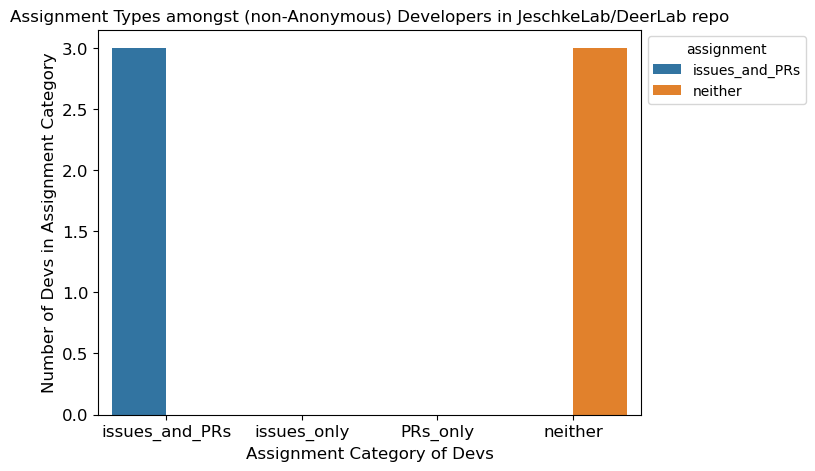

In [141]:
from ast import literal_eval

repo_name = 'JeschkeLab/DeerLab'
issues_data = '../../data/all-issues_JeschkeLab-DeerLab_2024-02-22.csv'
contributors_file = "../../data/contributors_JeschkeLab-DeerLab_2024-02-27.csv"

# read in dataset, explode to deal with multiple assignments on same item  
issues_df = pd.read_csv(issues_data, header=0) 

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned') 

# group by dev
grouped = exploded_devs.groupby('assigned_devs')

all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    #print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}

all_devs_df = pd.DataFrame.from_dict(all_devs)

# read in contributors data and rename 'login' field as 'dev_name' as later joining key  
contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df['dev_name'] = contributors_df['login']

# do outer join on both issues and contributors datasets on dev_name column (full outer join so we don't lose any devs not in other df)    
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

# drop extra columns brought in from contributors dataset  
joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'login', 'type', 'contributions', 'email', 'name']]

# fill columns from all_devs_df with 0s for newly added devs w/o assignments info from other table    
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] > 1) & (joinage['issues'] > 1),
    (joinage['PRs'] == 0) & (joinage['issues'] > 1),
    (joinage['PRs'] > 1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

# remove non-named-dev entries from joined dataset  
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

#  | dev_name | total | PRs | issues | assignment | login | type | contributions | email | name
# -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | --
# HKaras | 22.0 | 12.0 | 10.0 | issues_and_PRs | HKaras | User | 17.0 | NaN | NaN
# luisfabib | 115.0 | 67.0 | 48.0 | issues_and_PRs | luisfabib | User | 382.0 | NaN | NaN
# stestoll | 16.0 | 14.0 | 2.0 | issues_and_PRs | stestoll | User | 65.0 | NaN | NaN
# mtessmer | 0.0 | 0.0 | 0.0 | neither | mtessmer | User | 14.0 | NaN | NaN
# laenan8466 | 0.0 | 0.0 | 0.0 | neither | laenan8466 | User | 1.0 | NaN | NaN
# edmundxcvi | 0.0 | 0.0 | 0.0 | neither | edmundxcvi | User | 1.0 | NaN | NaN

# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")

           dev_name  total   PRs  issues            login  type  \
0           ElineVG    1.0   1.0     0.0          ElineVG  User   
1     MatthewWilkes   17.0   3.0    14.0    MatthewWilkes  User   
2            alecpm   66.0   8.0    58.0           alecpm  User   
3          cguardia   12.0   2.0    10.0         cguardia  User   
4     chiruzzimarco    2.0   0.0     2.0    chiruzzimarco  User   
5         davisagli    3.0   0.0     3.0        davisagli  User   
6          fmhoeger  108.0  75.0    33.0         fmhoeger  User   
7           jacobyn    4.0   1.0     3.0              NaN   NaN   
8        jcpeterson    1.0   1.0     0.0       jcpeterson  User   
9       jessesnyder   89.0  10.0    79.0      jessesnyder  User   
10      pmcharrison   32.0  21.0    11.0      pmcharrison  User   
11       polvanrijn    3.0   3.0     0.0       polvanrijn  User   
12          silviot   36.0   1.0    35.0          silviot  User   
13      skleinfeldt    1.0   0.0     1.0              NaN   Na

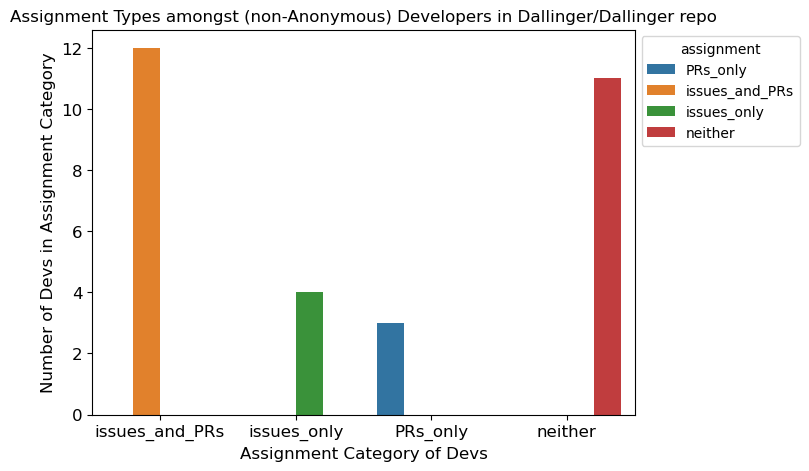

In [148]:
# Bigger Different Repo: 

from ast import literal_eval

repo_name = 'Dallinger/Dallinger'
issues_data = '../../data/all-issues_Dallinger-Dallinger_2024-02-27.csv'
contributors_file = "../../data/contributors_Dallinger-Dallinger_2024-02-27.csv"

# read in dataset, explode to deal with multiple assignments on same item  
issues_df = pd.read_csv(issues_data, header=0) 

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned') 

# group by dev
grouped = exploded_devs.groupby('assigned_devs')

all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    #print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}

all_devs_df = pd.DataFrame.from_dict(all_devs)

# read in contributors data and rename 'login' field as 'dev_name' as later joining key  
contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df['dev_name'] = contributors_df['login']

# do outer join on both issues and contributors datasets on dev_name column (full outer join so we don't lose any devs not in other df)    
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

# drop extra columns brought in from contributors dataset  
joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'login', 'type', 'contributions', 'email', 'name']]

# fill columns from all_devs_df with 0s for newly added devs w/o assignments info from other table    
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] >= 1) & (joinage['issues'] >= 1),
    (joinage['PRs'] == 0) & (joinage['issues'] >=1),
    (joinage['PRs'] >=1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

# remove non-named-dev entries from joined dataset  
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")

print(joinage)

current_date_info = datetime.now().strftime("%Y-%m-%d") # run this at start of script not in loop to avoid midnight/long-run issues
sanitised_repo_name = repo_name.replace("/", "-")
write_out = f'../../data/all-devs-assigned_{sanitised_repo_name}'
write_out_extra_info = f"{write_out}_{current_date_info}.csv" 

joinage.to_csv(write_out_extra_info, mode='w', index=True, header=True)

In [149]:
joinage['assignment'].value_counts()

issues_and_PRs    12
neither           11
issues_only        4
PRs_only           3
Name: assignment, dtype: int64

In [151]:
joinage['assignment'].value_counts()['issues_only']

4

In [4]:
repo_name = 'JeschkeLab/DeerLab'
issues_data = '../../data/all-issues_JeschkeLab-DeerLab_2024-02-22.csv'

issues_df = pd.read_csv(issues_data, header=0) 

print(issues_df.shape)
print(len(issues_df.index))
print(issues_df[issues_df.index==60])

(455, 33)
455
    Unnamed: 0                                                url  \
60          60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                     repository_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLab   

                                           labels_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                         comments_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                           events_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                            html_url          id  \
60  https://github.com/JeschkeLab/DeerLab/issues/403  1464493064   

               node_id  number  ... active_lock_reason draft pull_request  \
60  I_kwDOEIKXK85XSmQI     403  ...                NaN   NaN          NaN   

                                                 body  \
60  During the call to `import deerlab as 

In [5]:
# reshape dataset to make taller on 'assigned_devs' column (ie 1x row:[dev1, dev2]; -> 2x rows: dev1; dev2

from ast import literal_eval

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned')  

print(exploded_devs.shape)
print(len(exploded_devs.index))
print(exploded_devs[exploded_devs.index==60])

(456, 33)
456
    Unnamed: 0                                                url  \
60          60  https://api.github.com/repos/JeschkeLab/DeerLa...   
60          60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                     repository_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLab   
60  https://api.github.com/repos/JeschkeLab/DeerLab   

                                           labels_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLa...   
60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                         comments_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLa...   
60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                           events_url  \
60  https://api.github.com/repos/JeschkeLab/DeerLa...   
60  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                            html_url          id  \
60  https://github.com/Jesch

In [6]:
# this works now due to the literal_eval apply via SO: https://stackoverflow.com/a/63589387 
exploded_devs['assigned_devs'].value_counts(dropna=False)

unassigned    303
luisfabib     115
HKaras         22
stestoll       16
Name: assigned_devs, dtype: int64

In [7]:
# corroboration of those assignments
exploded_devs.groupby('assigned_devs').count()

,Unnamed: 0,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,...,author_association,active_lock_reason,draft,pull_request,body,reactions,timeline_url,performed_via_github_app,state_reason,is_PR
assigned_devs,,,,,,,,,,,,,,,,,,,,,
HKaras,22,22,22,22,22,22,22,22,22,22,...,22,0,12,12,19,22,22,0,9,22
luisfabib,115,115,115,115,115,115,115,115,115,115,...,115,0,76,76,106,101,110,5,44,115
stestoll,16,16,16,16,16,16,16,16,16,16,...,16,0,14,14,12,14,14,2,4,16
unassigned,303,303,303,303,303,303,303,303,303,303,...,303,0,198,214,241,219,250,53,138,303


In [8]:
grouped = exploded_devs.groupby('assigned_devs')

for name, group in grouped:  # via https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#iterating-through-groups
    print(f"Dev: {name}")
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    print(f"  Total assignments: {total_recs}") # using ID since it's guaranteed to be filled 
    print(f"  PRs: {total_PRs}")
    print(f"  Issues: {total_recs - total_PRs}")

Dev: HKaras
  Total assignments: 22
  PRs: 12
  Issues: 10
Dev: luisfabib
  Total assignments: 115
  PRs: 67
  Issues: 48
Dev: stestoll
  Total assignments: 16
  PRs: 14
  Issues: 2
Dev: unassigned
  Total assignments: 303
  PRs: 183
  Issues: 120


In [9]:
dev_dict = {}

dev_dict.update({'dev_name': name})
dev_dict.update({'total': total_recs})
dev_dict.update({'PRs': total_PRs})
dev_dict.update({'issues': total_recs - total_PRs})

print(dev_dict)

{'dev_name': 'unassigned', 'total': 303, 'PRs': 183, 'issues': 120}


In [10]:
all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}
    
print(all_devs)

all_devs_df = pd.DataFrame.from_dict(all_devs)
print(all_devs_df.shape)
print(all_devs_df)

{'dev_name': 'HKaras', 'total': 22, 'PRs': 12, 'issues': 10}
{'dev_name': 'luisfabib', 'total': 115, 'PRs': 67, 'issues': 48}
{'dev_name': 'stestoll', 'total': 16, 'PRs': 14, 'issues': 2}
{'dev_name': 'unassigned', 'total': 303, 'PRs': 183, 'issues': 120}
[{'dev_name': 'HKaras', 'total': 22, 'PRs': 12, 'issues': 10}, {'dev_name': 'luisfabib', 'total': 115, 'PRs': 67, 'issues': 48}, {'dev_name': 'stestoll', 'total': 16, 'PRs': 14, 'issues': 2}, {'dev_name': 'unassigned', 'total': 303, 'PRs': 183, 'issues': 120}]
(4, 4)
     dev_name  total  PRs  issues
0      HKaras     22   12      10
1   luisfabib    115   67      48
2    stestoll     16   14       2
3  unassigned    303  183     120


In [63]:
# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (all_devs_df['PRs'] > 1) & (all_devs_df['issues'] > 1),
    (all_devs_df['PRs'] == 0) & (all_devs_df['issues'] > 1),
    (all_devs_df['PRs'] > 1) & (all_devs_df['issues'] == 0),
    (all_devs_df['PRs'] == 0) & (all_devs_df['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
all_devs_df['assignment'] = np.select(conditions, choices, default='error')
print(all_devs_df)

# method via https://stackoverflow.com/a/19913845 

     dev_name  total  PRs  issues      assignment
0      HKaras     22   12      10  issues_and_PRs
1   luisfabib    115   67      48  issues_and_PRs
2    stestoll     16   14       2  issues_and_PRs
3  unassigned    303  183     120  issues_and_PRs


In [64]:
all_devs_df

,dev_name,total,PRs,issues,assignment
0,HKaras,22,12,10,issues_and_PRs
1,luisfabib,115,67,48,issues_and_PRs
2,stestoll,16,14,2,issues_and_PRs
3,unassigned,303,183,120,issues_and_PRs


In [37]:
all_devs_df_melt = pd.melt(all_devs_df, id_vars=['dev_name', 'assignment'], var_name='assigned_to', value_vars=['issues', 'PRs'], value_name='assignment_counts')
all_devs_df_melt

,dev_name,assignment,assigned_to,assignment_counts
0,HKaras,issues_and_PRs,issues,10
1,luisfabib,issues_and_PRs,issues,48
2,stestoll,issues_and_PRs,issues,2
3,unassigned,issues_and_PRs,issues,120
4,HKaras,issues_and_PRs,PRs,12
5,luisfabib,issues_and_PRs,PRs,67
6,stestoll,issues_and_PRs,PRs,14
7,unassigned,issues_and_PRs,PRs,183


Text(0.5, 1.0, 'Issue Ticket and Pull Request Assignment amongst Developers in JeschkeLab/DeerLab repo:  N = 456')

<Figure size 700x500 with 0 Axes>

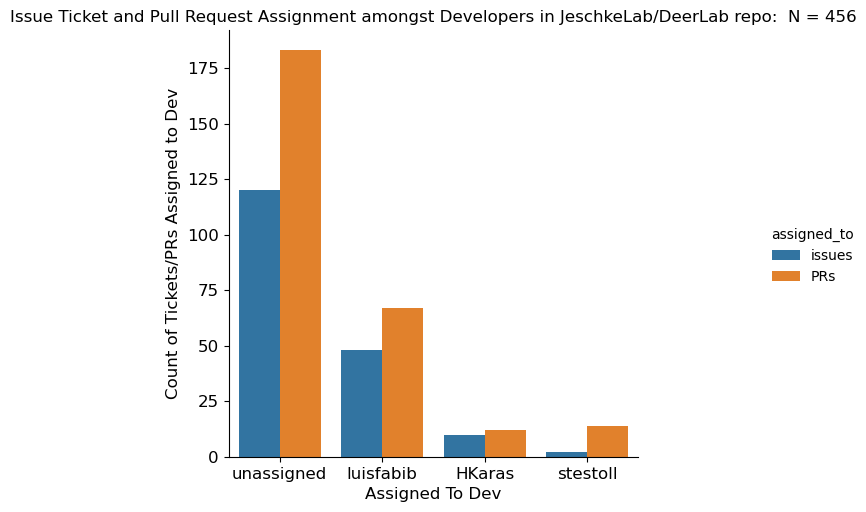

In [42]:
plt.figure(figsize=(7,5))
ax=sns.catplot(
    data=all_devs_df_melt, 
    x='dev_name',
    y='assignment_counts',
    hue='assigned_to', 
    kind='bar',
    order = exploded_devs['assigned_devs'].value_counts(dropna=False).index
)
all_tix=all_devs_df_melt.assignment_counts.sum()
plt.xticks(size=12)
plt.xlabel('Assigned To Dev', size=12)
plt.yticks(size=12)
plt.ylabel('Count of Tickets/PRs Assigned to Dev', size=12)
plt.title(f"Issue Ticket and Pull Request Assignment amongst Developers in {repo_name} repo:  N = {all_tix}")

In [65]:
all_devs_df['assignment'] = all_devs_df['assignment'].astype('category')

all_devs_df.dtypes


dev_name        object
total            int64
PRs              int64
issues           int64
assignment    category
dtype: object

In [66]:
all_devs_df['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

0    issues_and_PRs
1    issues_and_PRs
2    issues_and_PRs
3    issues_and_PRs
Name: assignment, dtype: category
Categories (4, object): ['issues_and_PRs', 'issues_only', 'PRs_only', 'neither']

Text(0.5, 1.0, 'Assignment Types amongst Developers in JeschkeLab/DeerLab repo')

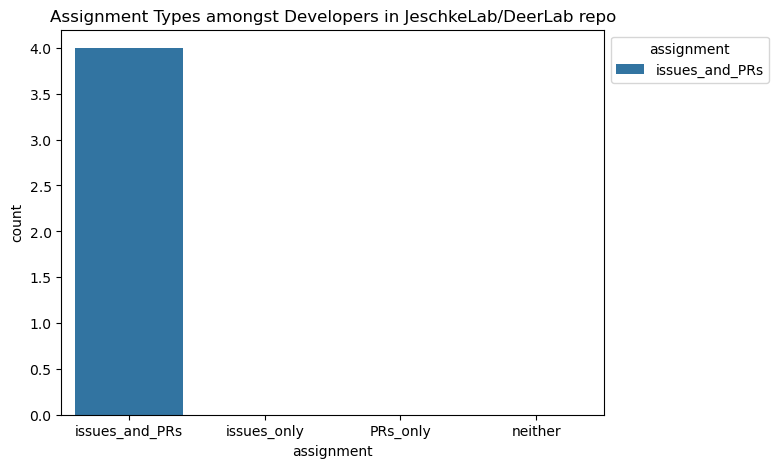

In [74]:
# make assignment a category datatype
all_devs_df['assignment'] = all_devs_df['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
all_devs_df['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=all_devs_df, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst Developers in {repo_name} repo")

## TODO:  
  # remove 'unassigned' from the counts for this plot  
  # see if it works for repos with differing assignments  
  # add non-assigned devs from 'contributors' data  
  # create a specific colour palette for issues (blue), PRs (orange), issues & PRs (?both?), and neither (grey?)    



In [76]:
# read in contributors data: 
contributors_file = "../../data/contributors_JeschkeLab-DeerLab_2024-02-27.csv"

contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df

,Unnamed: 0,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,...,subscriptions_url,organizations_url,repos_url,events_url,received_events_url,type,site_admin,contributions,email,name
0,0,luisfabib,48292540.0,MDQ6VXNlcjQ4MjkyNTQw,https://avatars.githubusercontent.com/u/482925...,NaN,https://api.github.com/users/luisfabib,https://github.com/luisfabib,https://api.github.com/users/luisfabib/followers,https://api.github.com/users/luisfabib/followi...,...,https://api.github.com/users/luisfabib/subscri...,https://api.github.com/users/luisfabib/orgs,https://api.github.com/users/luisfabib/repos,https://api.github.com/users/luisfabib/events{...,https://api.github.com/users/luisfabib/receive...,User,False,382,NaN,NaN
1,1,stestoll,9491761.0,MDQ6VXNlcjk0OTE3NjE=,https://avatars.githubusercontent.com/u/949176...,NaN,https://api.github.com/users/stestoll,https://github.com/stestoll,https://api.github.com/users/stestoll/followers,https://api.github.com/users/stestoll/followin...,...,https://api.github.com/users/stestoll/subscrip...,https://api.github.com/users/stestoll/orgs,https://api.github.com/users/stestoll/repos,https://api.github.com/users/stestoll/events{/...,https://api.github.com/users/stestoll/received...,User,False,65,NaN,NaN
2,2,HKaras,21962092.0,MDQ6VXNlcjIxOTYyMDky,https://avatars.githubusercontent.com/u/219620...,NaN,https://api.github.com/users/HKaras,https://github.com/HKaras,https://api.github.com/users/HKaras/followers,https://api.github.com/users/HKaras/following{...,...,https://api.github.com/users/HKaras/subscriptions,https://api.github.com/users/HKaras/orgs,https://api.github.com/users/HKaras/repos,https://api.github.com/users/HKaras/events{/pr...,https://api.github.com/users/HKaras/received_e...,User,False,17,NaN,NaN
3,3,mtessmer,18681246.0,MDQ6VXNlcjE4NjgxMjQ2,https://avatars.githubusercontent.com/u/186812...,NaN,https://api.github.com/users/mtessmer,https://github.com/mtessmer,https://api.github.com/users/mtessmer/followers,https://api.github.com/users/mtessmer/followin...,...,https://api.github.com/users/mtessmer/subscrip...,https://api.github.com/users/mtessmer/orgs,https://api.github.com/users/mtessmer/repos,https://api.github.com/users/mtessmer/events{/...,https://api.github.com/users/mtessmer/received...,User,False,14,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Anonymous,NaN,9,luisf@student.ethz.ch,Luis Fabregas
5,5,laenan8466,21331242.0,MDQ6VXNlcjIxMzMxMjQy,https://avatars.githubusercontent.com/u/213312...,NaN,https://api.github.com/users/laenan8466,https://github.com/laenan8466,https://api.github.com/users/laenan8466/followers,https://api.github.com/users/laenan8466/follow...,...,https://api.github.com/users/laenan8466/subscr...,https://api.github.com/users/laenan8466/orgs,https://api.github.com/users/laenan8466/repos,https://api.github.com/users/laenan8466/events...,https://api.github.com/users/laenan8466/receiv...,User,False,1,NaN,NaN
6,6,edmundxcvi,59712516.0,MDQ6VXNlcjU5NzEyNTE2,https://avatars.githubusercontent.com/u/597125...,NaN,https://api.github.com/users/edmundxcvi,https://github.com/edmundxcvi,https://api.github.com/users/edmundxcvi/followers,https://api.github.com/users/edmundxcvi/follow...,...,https://api.github.com/users/edmundxcvi/subscr...,https://api.github.com/users/edmundxcvi/orgs,https://api.github.com/users/edmundxcvi/repos,https://api.github.com/users/edmundxcvi/events...,https://api.github.com/users/edmundxcvi/receiv...,User,False,1,NaN,NaN


In [103]:
for dev in contributors_df['login']: 
    print(all_devs_df['dev_name'].str.contains(str(dev), regex=False))
    

0    False
1     True
2    False
3    False
Name: dev_name, dtype: bool
0    False
1    False
2     True
3    False
Name: dev_name, dtype: bool
0     True
1    False
2    False
3    False
Name: dev_name, dtype: bool
0    False
1    False
2    False
3    False
Name: dev_name, dtype: bool
0    False
1    False
2    False
3    False
Name: dev_name, dtype: bool
0    False
1    False
2    False
3    False
Name: dev_name, dtype: bool
0    False
1    False
2    False
3    False
Name: dev_name, dtype: bool


In [93]:
for dev in all_devs_df['dev_name']:
    print(dev)

HKaras
luisfabib
stestoll
unassigned
<class 'str'>


In [94]:
type(contributors_df['login'])

pandas.core.series.Series

In [95]:
contributors_df['login'].str.contains('HKaras')

0    False
1    False
2     True
3    False
4      NaN
5    False
6    False
Name: login, dtype: object

In [104]:
all_devs_df['dev_name']

0        HKaras
1     luisfabib
2      stestoll
3    unassigned
Name: dev_name, dtype: object

In [108]:
contributors_df['dev_name'] = contributors_df['login']
contributors_df

,Unnamed: 0,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,...,organizations_url,repos_url,events_url,received_events_url,type,site_admin,contributions,email,name,dev_name
0,0,luisfabib,48292540.0,MDQ6VXNlcjQ4MjkyNTQw,https://avatars.githubusercontent.com/u/482925...,NaN,https://api.github.com/users/luisfabib,https://github.com/luisfabib,https://api.github.com/users/luisfabib/followers,https://api.github.com/users/luisfabib/followi...,...,https://api.github.com/users/luisfabib/orgs,https://api.github.com/users/luisfabib/repos,https://api.github.com/users/luisfabib/events{...,https://api.github.com/users/luisfabib/receive...,User,False,382,NaN,NaN,luisfabib
1,1,stestoll,9491761.0,MDQ6VXNlcjk0OTE3NjE=,https://avatars.githubusercontent.com/u/949176...,NaN,https://api.github.com/users/stestoll,https://github.com/stestoll,https://api.github.com/users/stestoll/followers,https://api.github.com/users/stestoll/followin...,...,https://api.github.com/users/stestoll/orgs,https://api.github.com/users/stestoll/repos,https://api.github.com/users/stestoll/events{/...,https://api.github.com/users/stestoll/received...,User,False,65,NaN,NaN,stestoll
2,2,HKaras,21962092.0,MDQ6VXNlcjIxOTYyMDky,https://avatars.githubusercontent.com/u/219620...,NaN,https://api.github.com/users/HKaras,https://github.com/HKaras,https://api.github.com/users/HKaras/followers,https://api.github.com/users/HKaras/following{...,...,https://api.github.com/users/HKaras/orgs,https://api.github.com/users/HKaras/repos,https://api.github.com/users/HKaras/events{/pr...,https://api.github.com/users/HKaras/received_e...,User,False,17,NaN,NaN,HKaras
3,3,mtessmer,18681246.0,MDQ6VXNlcjE4NjgxMjQ2,https://avatars.githubusercontent.com/u/186812...,NaN,https://api.github.com/users/mtessmer,https://github.com/mtessmer,https://api.github.com/users/mtessmer/followers,https://api.github.com/users/mtessmer/followin...,...,https://api.github.com/users/mtessmer/orgs,https://api.github.com/users/mtessmer/repos,https://api.github.com/users/mtessmer/events{/...,https://api.github.com/users/mtessmer/received...,User,False,14,NaN,NaN,mtessmer
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Anonymous,NaN,9,luisf@student.ethz.ch,Luis Fabregas,NaN
5,5,laenan8466,21331242.0,MDQ6VXNlcjIxMzMxMjQy,https://avatars.githubusercontent.com/u/213312...,NaN,https://api.github.com/users/laenan8466,https://github.com/laenan8466,https://api.github.com/users/laenan8466/followers,https://api.github.com/users/laenan8466/follow...,...,https://api.github.com/users/laenan8466/orgs,https://api.github.com/users/laenan8466/repos,https://api.github.com/users/laenan8466/events...,https://api.github.com/users/laenan8466/receiv...,User,False,1,NaN,NaN,laenan8466
6,6,edmundxcvi,59712516.0,MDQ6VXNlcjU5NzEyNTE2,https://avatars.githubusercontent.com/u/597125...,NaN,https://api.github.com/users/edmundxcvi,https://github.com/edmundxcvi,https://api.github.com/users/edmundxcvi/followers,https://api.github.com/users/edmundxcvi/follow...,...,https://api.github.com/users/edmundxcvi/orgs,https://api.github.com/users/edmundxcvi/repos,https://api.github.com/users/edmundxcvi/events...,https://api.github.com/users/edmundxcvi/receiv...,User,False,1,NaN,NaN,edmundxcvi


In [125]:
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'assignment', 'login', 'type', 'contributions', 'email', 'name']]

In [126]:
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)
#joinage['dev_name'] = joinage['dev_name'].fillna(value='Anonymous')

#print(joinage)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] > 1) & (joinage['issues'] > 1),
    (joinage['PRs'] == 0) & (joinage['issues'] > 1),
    (joinage['PRs'] > 1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

print(joinage)


     dev_name  total    PRs  issues      assignment       login       type  \
0      HKaras   22.0   12.0    10.0  issues_and_PRs      HKaras       User   
1   luisfabib  115.0   67.0    48.0  issues_and_PRs   luisfabib       User   
2    stestoll   16.0   14.0     2.0  issues_and_PRs    stestoll       User   
3  unassigned  303.0  183.0   120.0  issues_and_PRs         NaN        NaN   
4    mtessmer    0.0    0.0     0.0         neither    mtessmer       User   
5         NaN    0.0    0.0     0.0         neither         NaN  Anonymous   
6  laenan8466    0.0    0.0     0.0         neither  laenan8466       User   
7  edmundxcvi    0.0    0.0     0.0         neither  edmundxcvi       User   

   contributions                  email           name  
0           17.0                    NaN            NaN  
1          382.0                    NaN            NaN  
2           65.0                    NaN            NaN  
3            NaN                    NaN            NaN  
4           

In [128]:
joinage.dtypes

dev_name          object
total            float64
PRs              float64
issues           float64
assignment        object
login             object
type              object
contributions    float64
email             object
name              object
dtype: object

In [135]:
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

joinage

,dev_name,total,PRs,issues,assignment,login,type,contributions,email,name
0,HKaras,22.0,12.0,10.0,issues_and_PRs,HKaras,User,17.0,NaN,NaN
1,luisfabib,115.0,67.0,48.0,issues_and_PRs,luisfabib,User,382.0,NaN,NaN
2,stestoll,16.0,14.0,2.0,issues_and_PRs,stestoll,User,65.0,NaN,NaN
4,mtessmer,0.0,0.0,0.0,neither,mtessmer,User,14.0,NaN,NaN
6,laenan8466,0.0,0.0,0.0,neither,laenan8466,User,1.0,NaN,NaN
7,edmundxcvi,0.0,0.0,0.0,neither,edmundxcvi,User,1.0,NaN,NaN


Text(0.5, 1.0, 'Assignment Types amongst (non-Anonymous) Developers in JeschkeLab/DeerLab repo')

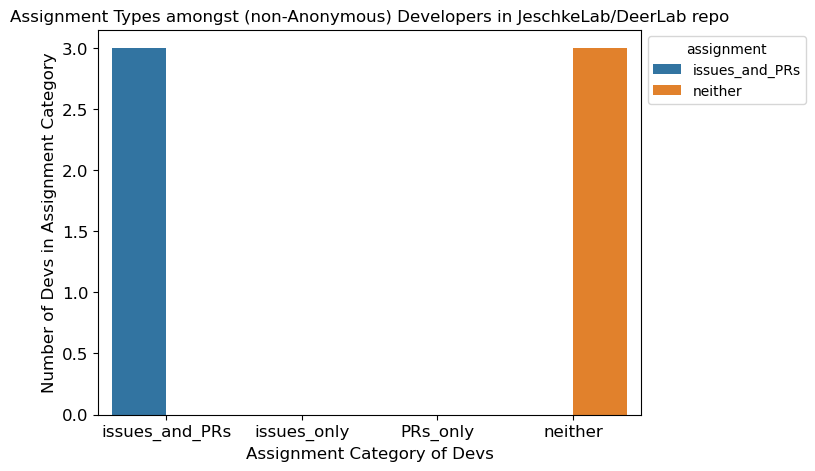

In [137]:
# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")


In [127]:
plt.figure(figsize=(7,5))
ax=sns.countplot(
    x='assignment', 
    hue='value',
    data=pd.melt(joinage) 
    #order = exploded_devs['assigned_devs'].value_counts(dropna=False).index  # order the bars; via https://stackoverflow.com/a/46624802
)
# plt.xticks(size=12)
# plt.xlabel('Assigned To User', size=12)
# plt.yticks(size=12)
# plt.ylabel('Count of Tickets Assigned', size=12)
# #plt.axhline(y=(all_tix*0.10), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 10% of all assigned tickets
# plt.title(f"Issue Ticket Assignment in {repo_name} repo:  N = {all_tix}")

ValueError: Could not interpret input 'assignment'

<Figure size 700x500 with 0 Axes>

In [42]:
this['assigned_devs'].value_counts(dropna=False)

[]                         303
['luisfabib']              114
['HKaras']                  21
['stestoll']                16
['HKaras', 'luisfabib']      1
Name: assigned_devs, dtype: int64

In [19]:
# number of PRs assigned to each dev
exploded_devs.groupby('assigned_devs')['is_PR'].sum()

assigned_devs
['HKaras', 'luisfabib']      0
['HKaras']                  12
['luisfabib']               67
['stestoll']                14
[]                         183
Name: is_PR, dtype: int64

In [28]:
exploded_devs.groupby('assigned_devs').count() 

,Unnamed: 0,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,...,author_association,active_lock_reason,draft,pull_request,body,reactions,timeline_url,performed_via_github_app,state_reason,is_PR
assigned_devs,,,,,,,,,,,,,,,,,,,,,
"['HKaras', 'luisfabib']",1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,0,1,1
['HKaras'],21,21,21,21,21,21,21,21,21,21,...,21,0,12,12,18,21,21,0,8,21
['luisfabib'],114,114,114,114,114,114,114,114,114,114,...,114,0,76,76,105,100,109,5,43,114
['stestoll'],16,16,16,16,16,16,16,16,16,16,...,16,0,14,14,12,14,14,2,4,16
[],303,303,303,303,303,303,303,303,303,303,...,303,0,198,214,241,219,250,53,138,303


In [4]:
#repo_name = 'MotionbyLearning/stm' # 61
repo_name = 'JeschkeLab/DeerLab'

import githubanalysis.processing.get_all_pages_issues
from githubanalysis.processing.get_all_pages_issues import IssueGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_NOTEBOOK_logs.txt')  
issues_getter = IssueGetter(logger)

iss_df = issues_getter.get_all_pages_issues(repo_name=repo_name, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')

INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 1 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 2 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 3 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 4 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 5 of 5.


In [5]:
iss_df.dtypes

url                         object
repository_url              object
labels_url                  object
comments_url                object
events_url                  object
html_url                    object
id                           int64
node_id                     object
number                       int64
title                       object
user                        object
labels                      object
state                       object
locked                        bool
assignee                    object
assignees                   object
milestone                   object
comments                     int64
created_at                  object
updated_at                  object
closed_at                   object
author_association          object
active_lock_reason          object
draft                       object
pull_request                object
body                        object
reactions                   object
timeline_url                object
performed_via_github

In [13]:
print(iss_df)

                                                  url  \
0   https://api.github.com/repos/JeschkeLab/DeerLa...   
1   https://api.github.com/repos/JeschkeLab/DeerLa...   
2   https://api.github.com/repos/JeschkeLab/DeerLa...   
3   https://api.github.com/repos/JeschkeLab/DeerLa...   
4   https://api.github.com/repos/JeschkeLab/DeerLa...   
..                                                ...   
50  https://api.github.com/repos/JeschkeLab/DeerLa...   
51  https://api.github.com/repos/JeschkeLab/DeerLa...   
52  https://api.github.com/repos/JeschkeLab/DeerLa...   
53  https://api.github.com/repos/JeschkeLab/DeerLa...   
54  https://api.github.com/repos/JeschkeLab/DeerLa...   

                                     repository_url  \
0   https://api.github.com/repos/JeschkeLab/DeerLab   
1   https://api.github.com/repos/JeschkeLab/DeerLab   
2   https://api.github.com/repos/JeschkeLab/DeerLab   
3   https://api.github.com/repos/JeschkeLab/DeerLab   
4   https://api.github.com/repos/Jeschke

In [6]:
iss_df.state.value_counts().open

5

In [7]:
print(f"issue state counts: {iss_df.state.value_counts()}")

issue state counts: closed    450
open        5
Name: state, dtype: int64


In [8]:
print(iss_df['pull_request'])

0     {'url': 'https://api.github.com/repos/JeschkeL...
1     {'url': 'https://api.github.com/repos/JeschkeL...
2     {'url': 'https://api.github.com/repos/JeschkeL...
3                                                   NaN
4                                                   NaN
                            ...                        
50    {'url': 'https://api.github.com/repos/JeschkeL...
51    {'url': 'https://api.github.com/repos/JeschkeL...
52    {'url': 'https://api.github.com/repos/JeschkeL...
53    {'url': 'https://api.github.com/repos/JeschkeL...
54    {'url': 'https://api.github.com/repos/JeschkeL...
Name: pull_request, Length: 455, dtype: object


In [21]:
iss_df['pull_request'].isna()

AttributeError: 'Series' object has no attribute 'counts'

In [33]:
#iss_df['is_PR'] = iss_df['pull_request'].notna()
iss_df['is_PR'].value_counts()

True     276
False    179
Name: is_PR, dtype: int64

In [32]:
iss_df['is_PR'].value_counts()[True]

276

In [11]:
iss_df

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,active_lock_reason,draft,pull_request,body,reactions,timeline_url,performed_via_github_app,state_reason,assigned_devs,is_PR
0,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/pull/467,1974618327,PR_kwDOEIKXK85ec-82,467,Push patch into V1.1,...,None,False,{'url': 'https://api.github.com/repos/JeschkeL...,None,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,None,None,[],True
1,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/pull/466,1974616835,PR_kwDOEIKXK85ec-oE,466,Update changelog.rst for new release,...,None,False,{'url': 'https://api.github.com/repos/JeschkeL...,None,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,None,None,[],True
2,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/pull/464,1926248838,PR_kwDOEIKXK85b5xEU,464,Fixing Sophgrid bug,...,None,False,{'url': 'https://api.github.com/repos/JeschkeL...,Fixes the bug in the `sophgrid` function highl...,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,None,None,[HKaras],True
3,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/issues/463,1925610074,I_kwDOEIKXK85yxnpa,463,SOPHE grid implementation differs from EASYSPIN,...,None,NaN,NaN,Hi!\r\n\r\nIt seems to me that the implementat...,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,None,completed,[HKaras],False
4,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/issues/462,1884034188,I_kwDOEIKXK85wTBSM,462,Fix warning with Tqdm when programing in jupyter,...,None,NaN,NaN,When using deerlab in jupyter the following wa...,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,None,None,[],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/pull/5,655081818,MDExOlB1bGxSZXF1ZXN0NDQ3Njc5NTE3,5,Removed pandas dependency,...,None,False,{'url': 'https://api.github.com/repos/JeschkeL...,,{'url': 'https://api.github.com/repos/JeschkeL...,https://api.github.com/repos/JeschkeLab/DeerLa...,None,None,[],True
51,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLab,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://api.github.com/repos/JeschkeLab/DeerLa...,https://github.com/JeschkeLab/DeerLab/pull/4,654982730,MDEx

In [12]:
iss_df[''] = 

SyntaxError: invalid syntax (457180413.py, line 1)

In [ ]:
iss_devs = get_assignee.get_issue_assignees(iss_df)

In [25]:
iss_devs.assigned_devs.value_counts()

NameError: name 'iss_devs' is not defined

In [ ]:
# reshape dataset to make taller on 'assigned_devs' column (ie 1x row:[dev1, dev2]; -> 2x rows: dev1; dev2
exploded_devs = iss_devs.apply(pd.Series).explode(column='assigned_devs', ignore_index=True)

In [ ]:
exploded_devs.assigned_devs.value_counts(normalize=True, dropna=False)

In [ ]:
# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]])
#non_assigned = all_tix - total_assigned
non_assigned_text = f'{all_tix - total_assigned} Unassigned tickets (N = {all_tix})'

print(exploded_devs['assigned_devs'].value_counts(dropna=False))  # print per-dev assignment counts

# do actual plotting:
exploded_devs['assigned_devs'].value_counts(normalize=True, dropna=False).plot.bar(column='assigned_devs', color='red', label='assigned tickets')

plt.xlabel("Assigned To user")
plt.ylabel("Proportion of issue tickets assigned")
plt.title(f"Proportion of assigned issue tickets per dev for repo: {repo_name}")
plt.axhline(y=(0.25), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 25% of all closed assigned tickets
plt.plot([], [], ' ', label=non_assigned_text)  # Create empty plot with blank marker containing the extra label
plt.legend(loc='upper right')

In [ ]:
# plot issue ticket assignment proportions amongst devs for 1 repo

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    # method for plotting percentages onto seaborn plot without hue via https://stackoverflow.com/a/62076347

# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
#total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]]) # used by axhline label if used

    
# deal with NaNs: 
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned')   # via https://stackoverflow.com/a/46415931

plt.figure(figsize=(7,5))
ax=sns.countplot(
    x='assigned_devs', 
    data=exploded_devs, 
    order = exploded_devs['assigned_devs'].value_counts(dropna=False).index  # order the bars; via https://stackoverflow.com/a/46624802
)
plt.xticks(size=12)
plt.xlabel('Assigned To User', size=12)
plt.yticks(size=12)
plt.ylabel('Count of Tickets Assigned', size=12)
#plt.axhline(y=(all_tix*0.10), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 10% of all assigned tickets
plt.title(f"Issue Ticket Assignment in {repo_name} repo:  N = {all_tix}")


without_hue(ax, exploded_devs.assigned_devs)

In [ ]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("tips")
x, y, hue = "day", "proportion", "sex"
hue_order = ["Male", "Female"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

### Load 1 repo content via get_repo_connection() 

In [ ]:
# repo_con = ghconnect.get_repo_connection(repo_name='harnesscloud/irm-nova', config_path='../../githubanalysis/config.cfg')
# repo_con = repo_con.json()
# print(repo_con)

### Load 1 repo content via s.get() 

In [ ]:
# gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
# headers = {'Authorization': 'token ' + gh_token}

# s = requests.Session()
# retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
# s.mount('https://', HTTPAdapter(max_retries=retries))

### Load repo stats file

In [ ]:
total_stats = pd.read_csv("../../data/gh_stats_2024-02-14-eidf.csv", header=0, nrows=250)
print(total_stats.head)

In [ ]:
len(total_stats.index) # number of records (so far)

In [ ]:
total_stats['initial_HTTP_code'].value_counts()

## Subset: only non-404 repos:

In [ ]:
total_stats_200s = total_stats[total_stats['initial_HTTP_code'] == 200]

#total_stats_200s[['devs', 'repo_age_days', 'total_commits_last_year']].describe()

In [ ]:
total_stats_200s['has_issues'] = np.where((total_stats_200s['open_tickets'] > 1) | (total_stats_200s['closed_tickets'] > 1), True, False)
total_stats_200s['all_tickets'] = (total_stats_200s['open_tickets'] + total_stats_200s['closed_tickets'])

#print(total_stats_200s)

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

In [ ]:
# Find the outlier: 
# https://github.com/swsoyee/2019-ncov-japan/issues 
# "Interactive dashboard for real-time recording of COVID-19 outbreak in Japan"
total_stats_200s[total_stats_200s['closed_tickets'] > 16900]

In [ ]:
tmp = total_stats_200s.drop([93])
tmp[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

## remove closed_tickets outlier  

In [ ]:
total_stats_200s = total_stats_200s.drop([93])

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

Starting number: 250 records.

Data excluded:  
 - 404 repos (may have been made private, or deleted?)  (removes 3 records) 
 - huge outlier of closed_tickets (removes 1 record)   
 
Possibly worth excluding further: 
 - repos with < 50 devs (removes 2 records from the set) 
 - repos which are a fork? (removes 11 records) 
 

Key interesting points: 

 - issue-using repos:  
   - are older on average  
   - are more active (higher commits in last year)  
   - have larger numbers of devs in the repo  
 
 - solo-dev repos are SUPER COMMON; repos with more than 10 devs are much less common.    
 
 - there's a difference in behaviour between repos using issues vs not using issues in YOUNG repos (~1st year; < 500 days) in their commit activity in the last year. Repos not using issues tend to have lower numbers of commits in their first year; there are fewer repos using issues in the first year, but all have fairly high commits in their first year. This isn't explained by forked-ness.  
 
 - Repos up to 5 years are the most common. Again, seeing the split between issue use here... Age distribution is fairly even amongst issue-users, but NOT non-issues-users.
 

Worth investigating:  
 - Zenodo record creation dates vs github repo ages  
 - actual commits data (not just number of commits in last year)  
 - binning devs numbers: 1, 2-5, 6+ and plotting out behaviours with   
 
 

In [ ]:
repo_name = 'MotionbyLearning/stm' # 61
#repo_name = 'nicolasfara/reconfiguration-experiments'

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {'Authorization': 'token ' + gh_token}

s = requests.Session()
retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
s.mount('https://', HTTPAdapter(max_retries=retries))

In [ ]:
state='all'
issues_url = f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&pulls=false"
#print(issues_url)

api_response = s.get(url=issues_url, headers=headers)

In [ ]:
#dir(api_response)

In [ ]:
print(api_response.links)

In [ ]:
issue_links = api_response.links

if 'last' in issue_links:
    issue_links_last = issue_links['last']['url'].split("&page=")[1]
    pages_issues = int(issue_links_last)

    print(pages_issues)

In [ ]:
#df_js = pd.read_json('https://api.github.com/repositories/693656185/issues?state=all&per_page=100&page=2&pulls=false')

In [ ]:
#print(df_js)

In [ ]:
# r = range(1,5)
# for i in r:
#     print(i)

In [ ]:
pg_range = range(1, (pages_issues+1))
all_issues = pd.DataFrame()
store_pgs = pd.DataFrame()

print(pg_range)


for i in pg_range: 
    print(i)
    store_pgs = pd.read_json(path_or_buf=f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&page={i}&pulls=false")
    all_issues = pd.concat([all_issues, store_pgs], )

print(len(all_issues.index))
print(len(store_pgs.index))


In [ ]:
all_issues

In [ ]:
print(iss_df)

In [ ]:
iss_df.dtypes

In [ ]:
iss_df.state

### Key stats differences between issues-users and non-issue-users

In [ ]:
total_stats_200s.groupby('has_issues').mean(numeric_only=True)

## Distribution of repo ages: bar per year of age  (split by issue-use)

In [ ]:
sns.displot(data=total_stats_200s, x='repo_age_days', binwidth=365, col='has_issues')

In [ ]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)

#print(total_stats_200s['repo_age_years'])

ax = sns.barplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', estimator='mean', errorbar=None)
#ax.bar_label(ax.containers[0].round(2), fontsize=10);

In [ ]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)
total_stats_200s = total_stats_200s.astype({'repo_age_years': int})

#print(total_stats_200s['repo_age_years'])


plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=None)
#plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=('se'))
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Average Number of Commits in Last Year by Repository Ages: N={len(total_stats_200s.repo_name)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Average Commits in Last Year', size=12)


for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

In [ ]:
plot = sns.catplot(data=total_stats_200s, x='repo_age_years', kind='count')
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Number of Repositories at Each Age in Years: N={len(total_stats_200s)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Repositories', size=12)

# add values to bars (integers)
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2 decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

In [ ]:
repos_7yrs = total_stats_200s[total_stats_200s['repo_age_years'] == 7]

len(repos_7yrs.index)

#repos_7yrs[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

#repos_7yrs[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].median()

repos_7yrs['total_commits_last_year'].describe()


In [ ]:
sns.countplot(data=repos_7yrs, x='total_commits_last_year')

In [ ]:
print(repos_7yrs[repos_7yrs['total_commits_last_year'] == 108]) # get this specific datapoint ^

total_stats_200s[total_stats_200s['repo_name'] == 'SciTools/python-stratify']  # pull out its whole record.

## Number of Devs Per Repo (mostly under 10, averages ~5)

In [ ]:
# Devs per Repo
# PLOT ALL DEVS
sns.displot(data=total_stats_200s, x='devs')

In [ ]:
# PLOT UNDER 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] < 50]
sns.histplot(data=smaller_teams, x='devs', discrete=True)
#len(smaller_teams) # 244
#len(total_stats_200s) #246

In [ ]:
# PLOT UNDER 20 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 20]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

In [ ]:
# PLOT 10 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 10]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

### more devs more tickets!

In [ ]:
sns.scatterplot(data=total_stats_200s, x='devs', y='all_tickets')

In [ ]:
# ZOOM IN ON Devs vs Tickets! 
# PLOT 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 50]
sns.scatterplot(data=smaller_teams, x='devs', y='all_tickets')

## Forks don't really make much difference to the data? 

# latest commit activity differs...

In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

sns.histplot(
    data=total_stats_200s, 
    x='repo_age_days', 
    y='total_commits_last_year',  
    #hue='has_issues', 
    stat='count',
    #binwidth='365',
    discrete=True
)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

### All Repos (including zero commits in last year): commits activity in last year by repo age (UP TO 1000 DAYS)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(first_1k_days, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (FIRST 1000 DAYS ONLY) (size ='N devs')")

## Active Repos: Commits Activity in Last Year by Repo Age

In [ ]:
active_repos = total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1]
len(active_repos) # 77
#print(active_repos)

#first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(active_repos, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days AMONGST ACTIVE REPOS ONLY (>1 commit in last year) (size ='N devs')")


In [ ]:
total_stats_200s['issues_enabled'].value_counts() 


In [ ]:
(total_stats_200s['all_tickets'] == 0).sum() # 171 records with 0 issues

In [ ]:
(total_stats_200s['all_tickets'] > 0).sum() # 75 records with 1+ issues

In [ ]:
total_stats_200s['has_PRs'].value_counts()

In [ ]:
total_stats_200s['repo_is_fork'].value_counts()

In [ ]:
total_stats_200s

In [ ]:
total_stats_200s.describe()

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='repo_age_days', y='devs', alpha=0.5, hue='repo_is_fork'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
len(total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1].index)
# 77 repos with more than 1 commit last year...

### Total commits in last year by repo age; split by using issues

In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

In [ ]:
# SAME PLOT BUT WITH 'RUG' TICKS ON AXES
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp = g.map_dataframe(sns.rugplot, x='repo_age_days', y='total_commits_last_year', height=-.02, clip_on=False)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

In [ ]:
print(total_stats_200s.dtypes)

In [ ]:
sns.histplot(data=total_stats_200s, x ='closed_tickets', stat='count', discrete=True)

In [ ]:
sns.histplot(data=total_stats_200s, x ='open_tickets', stat='count', discrete=True)


In [ ]:
sns.histplot(data=total_stats_200s, x ='all_tickets')

In [ ]:
# # plot setup  
# (sns.set_theme(), 
#  sns.set_palette('colorblind'),
#  #plt.subplots(figsize=(8,8)),
#  sns.relplot(
#      data=active_repos, x='total_commits_last_year', y='devs', hue='has_PRs', alpha=0.5
#  ), 
#  #plt.xscale('log'),
#  #plt.yscale('log') 
# )

In [ ]:
# # plot setup  
# sns.set_theme() 
# sns.set_palette('colorblind')

# g = sns.FacetGrid(active_repos, hue='has_PRs', col='has_PRs', margin_titles=True, height=6, sharey=True, sharex=False)
# rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
# rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
# #rp.fig.subplot.scale(y='log')
# rp.fig.suptitle("Repos Active within Last Year: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

# total commits last year vs dev count in active repos

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='total_commits_last_year', y='devs'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

# number of devs in active (commit in last year) repos

In [ ]:
bins=[1, 2, 5, 10]


# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.displot(
     data=total_stats_200s, x='devs', discrete=True
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
ax = sns.countplot(data=total_stats, x='initial_HTTP_code')
ax.set_title(f"HTTP Response Codes for GitHub Repositories; N={len(total_stats.index)}")
ax.bar_label(ax.containers[0])

In [ ]:
             # get repo_name from commandline if given (accept commandline input) 

        if len(sys.argv) == 2:
            repo_name = sys.argv[1]  # use second argv (user-provided by commandline)
            self.logger.info(f"Using commandline argument {repo_name} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[1]}. ")
            if not isinstance(repo_name, str):
                raise TypeError("Ensure argument is repository name in string format (e.g. 'repo-owner/repo-name')")
    
    
        if len(sys.argv) >= 3:
                issues_filename = sys.argv[2]  # use third argv (user-provided by commandline)
                self.logger.info(f"Using commandline argument {issues_filename} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[2]}. ")
                if not isinstance(issues_filename, str):
                    raise TypeError("Ensure argument is issues dataset in string format (e.g. 'all-issues_JeschkeLab-DeerLab_2024-02-27')")
            if len(sys.argv) >= 4:
                try:
                    contributors_filename = sys.argv[3] # use fourth argv as location of issues data if given  
                    self.logger.info(f"Using commandline argument {contributors_filename} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[3]}. ")            
                    if not isinstance(contributors_filename, str):
                        raise TypeError("Ensure argument is contributors dataset in string format (e.g. 'all-issues_JeschkeLab-DeerLab_2024-02-27')")           
                  else: 
            try:
                repo_name = repo_name
                issues_filename = issues_filename
                contributors_filename = contributors_filename
                self.logger.debug(f"Repo name is {repo_name}. Getting issues.")
                self.logger.debug(f"Issues dataset is {issues_filename}.")
                self.logger.debug(f"Contributors dataset is {contributors_filename}.")
            except:
                raise IndexError("Please enter a repo_name (NECCESSARY), issues_filename (optional) and contributors_filename (optional) all as 'quoted strings' separated by a space...")

        if repo_name is None:
            raise ValueError("No repo_name value has been given - this is required.")
        
        if issues_filename is None:
            try:
                logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_logs.txt')  
                issues_getter = IssueGetter(logger)
                issues_df = issues_getter.get_all_pages_issues(repo_name=repo_name, config_path=config_path, write_out_location=read_in_location)
            except Exception as e_get_issues:
                self.logger.error(f"Error while trying to run get_all_pages_issues(): {e_get_issues}.")
        if contributors_filename is None:
            try:
                logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='logs/get_repo_contributors_logs.txt')
                devs_getter = DevsGetter(logger)
                contributors_df = devs_getter.get_repo_contributors(repo_name=repo_name, config_path=config_path, write_out_location=read_in_location)
            except Exception as e_get_contributors:
                self.logger.error(f"Error while trying to run get_repo_contributors(): {e_get_contributors}.")

### get stats for 1 repo  

In [ ]:
#config_path = '../../githubanalysis/config.cfg'

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

In [ ]:
gh_urls_df = pd.read_csv("../../data/todo_2024-02-06.csv", header=0, usecols=['ZenodoID', 'repo_name'], dtype={'ZenodoID':'Int64', 'repo_name':'str'})
gh_urls_df.shape

In [ ]:
gh_urls_df_short = gh_urls_df[30:50]
print(gh_urls_df_short)

In [ ]:
rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo}")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_short = gh_urls_df[60:80]
print(gh_urls_df_short)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_ton = gh_urls_df[0:100]
#print(gh_urls_df_ton)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_ton.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    logger.info(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)